# Importaçoes

In [3]:
import numpy as np 
import pandas as pd 


import os
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, LSTM, Embedding, Flatten, Input, Dropout, add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from PIL import Image
from tqdm import tqdm
import pickle
import re


2025-01-08 21:46:57.365760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 21:46:57.396335: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 21:46:57.396369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 21:46:57.397109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 21:46:57.402162: I tensorflow/core/platform/cpu_feature_guar

# Abrindo os dados

In [4]:
#Images folder path
IMAGES_PATH = "Images"
#Caption CSV file path
CAPTIONS_PATH = "captions.txt"

In [5]:
df = pd.read_csv(CAPTIONS_PATH, on_bad_lines='skip', sep = ",")
df = df.dropna()
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


## Filtrando as legendas

Nessa seçao filtraremos as legendas, tornando elas minusculas, removendo palavras de tamanho igual a um, pois elas pioram as legendas geradas, alem de adicionar duas palavras especiais de começo e final de sequencia.

Também faremos um dicionario onde as chaves serão os nomes dos arquivos e os valores serão as legendas de cada arquivo(um vetor de strings).

In [6]:
def clean(captions):
    # Convert to lowercase
    captions = captions.lower()
    # Remove numbers, special characters, e o caractere '
    captions = re.sub(r"[^a-z\s]", "", captions)
    # Replace multiple spaces with a single space
    captions = re.sub(r'\s+', ' ', captions).strip()
    # Add start and end sequence tokens
    captions = 'startseq ' + " ".join([word for word in captions.split() if len(word) > 1]) + ' endseq'
    return captions


In [7]:
df["caption"] = df["caption"].apply(clean)
for cap in df["caption"].values[:5]:
    print(cap)

startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


In [8]:
dict_img_to_captions = {}
for i in range(len(df)):
    row = df.iloc[i]
    img = row["image"]
    cap = row["caption"]
    if dict_img_to_captions.get(img) is None:
        dict_img_to_captions[img] = []
    dict_img_to_captions[img].append(cap)

## Tokenizando

Nessa seçao ajustaremos o tokenizer, que será mais util na hora de gerar as entradas para o modelo

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["caption"].values)

In [10]:
for i in df["caption"].values[:2]:
    print(i)
    print(tokenizer.texts_to_sequences([i])[0])
    print()

startseq child in pink dress is climbing up set of stairs in an entry way endseq
[1, 41, 3, 89, 168, 6, 118, 52, 393, 11, 390, 3, 27, 5192, 691, 2]

startseq girl going into wooden building endseq
[1, 18, 312, 63, 192, 116, 2]



# Extraindo features das imagens

Aqui usaremos uma rede pré treinada, chamada de VGG16 para extrair as features de todas as imagens do nosso conjunto de dados.

Também criaremos um novo dicionario, de imagem para vetor de caracteristicas e o salvaremos para evitar computações desnecessarias em execuções posteriores.

Extrair as features de antemão ajuda a economizar muita memoria e tempo na hora de treinar o modelo.

In [11]:
from tensorflow.keras.applications import VGG16

def create_vgg_feature_extractor():
    base_model = VGG16()
    return Model(inputs = base_model.inputs , outputs = base_model.layers[-3].output, name="VGG_FeatureExtractor")

vgg_feature_extractor = create_vgg_feature_extractor()
print(vgg_feature_extractor.summary())

Model: "VGG_FeatureExtractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

In [12]:
dummy_input = np.random.randn(1, 224, 224, 3)
dummy_output = vgg_feature_extractor.predict(dummy_input)
dummy_output.shape

1/1 [==============================] - 0s 247ms/step


(1, 4096)

In [13]:
def transform_image(image):
    # Redimensiona a imagem para 224x224
    image = image.resize((224, 224))
    # Converte a imagem para um array numpy
    image_array = np.array(image)
    # Adiciona uma dimensão para representar o lote
    image_array = np.expand_dims(image_array, axis=0)
    # Pré-processa a imagem para o modelo ResNet50
    image_array = tf.keras.applications.resnet50.preprocess_input(image_array)
    return image_array

### Salvando o vetor das imagens

In [114]:
# from concurrent.futures import ThreadPoolExecutor, as_completed

# def process_image(img):
#     img_path = os.path.join(IMAGES_PATH, img)
#     image = Image.open(img_path)
#     image = transform_image(image)
#     features = vgg_feature_extractor.predict(image, verbose=0)
#     return img, features

# vetor_imagens = {}
# for img in tqdm(os.listdir(IMAGES_PATH)):
#     img, feat = process_image(img)
#     vetor_imagens[img] = feat

100%|██████████| 8091/8091 [08:02<00:00, 16.77it/s]


In [14]:
pickle_file_path = 'model/vetor_imagens.pkl'

# with open(pickle_file_path, 'wb') as f:
#     pickle.dump(vetor_imagens, f)

# print(f'Dicionário salvo como pickle em {pickle_file_path}')

In [15]:
# load features from pickle
with open(pickle_file_path, 'rb') as f:
    vetor_imagens = pickle.load(f)
    print(f'Dicionário carregado de {pickle_file_path}')

Dicionário carregado de model/vetor_imagens.pkl


# Modelo

Aqui definimos nosso modelo, que recebera duas entradas, a primeira sendo o vetor de features da imagem, e sua legenda.

In [17]:
intern_layer = 256
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(i.split()) for i in df["caption"].values])

## Usando embbed do bert

In [18]:
model_name = "bert-base-uncased"
hf_tokenizer = AutoTokenizer.from_pretrained(model_name)
hf_model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [19]:
# Extrair a matriz de embeddings completa
embedding_layer = hf_model.get_input_embeddings()
embedding_matrix_full = embedding_layer.weight.numpy()

In [20]:
embedding_dim = embedding_matrix_full.shape[1]
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [21]:
c=0
o=0
for word, index in tokenizer.word_index.items():
    if word in hf_tokenizer.vocab:  # Verificar se o token existe no vocabulário do modelo
        c+=1
        hf_index = hf_tokenizer.convert_tokens_to_ids(word)
        embedding_matrix[index] = embedding_matrix_full[hf_index]
    else:
        # Para tokens fora do vocabulário do modelo, usar vetores zerados ou aleatórios
        o+=1
        embedding_matrix[index] = np.random.normal(size=(embedding_dim,))
print(f"Sem embed pronto: {o}")
print(f"Com embed pronto: {c}")
embedding_matrix.shape

Sem embed pronto: 3376
Com embed pronto: 5391


(8768, 768)

## Modelo final

In [22]:
caption_network = keras.Sequential([
    Input(shape=(max_length,)),
    Embedding(vocab_size, embedding_dim,weights=[embedding_matrix], mask_zero=True),
    Dropout(0.5),
    LSTM(256, return_sequences=True),
    LSTM(256),
    Dense(intern_layer, activation='relu'),
    ]
)

image_network = keras.Sequential([
    Input(shape=(4096,)),
    #Dense(intern_layer, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    ]
)

#combined_network = add([caption_network.output, image_network.output])
combined_network = add([caption_network.output, image_network.output])
dropout = Dropout(0.35)(combined_network)
combined_network = Dense(256, activation='relu')(combined_network)
output = Dense(vocab_size, activation='softmax')(combined_network)

In [23]:
model = Model(inputs=[image_network.input, caption_network.input ], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

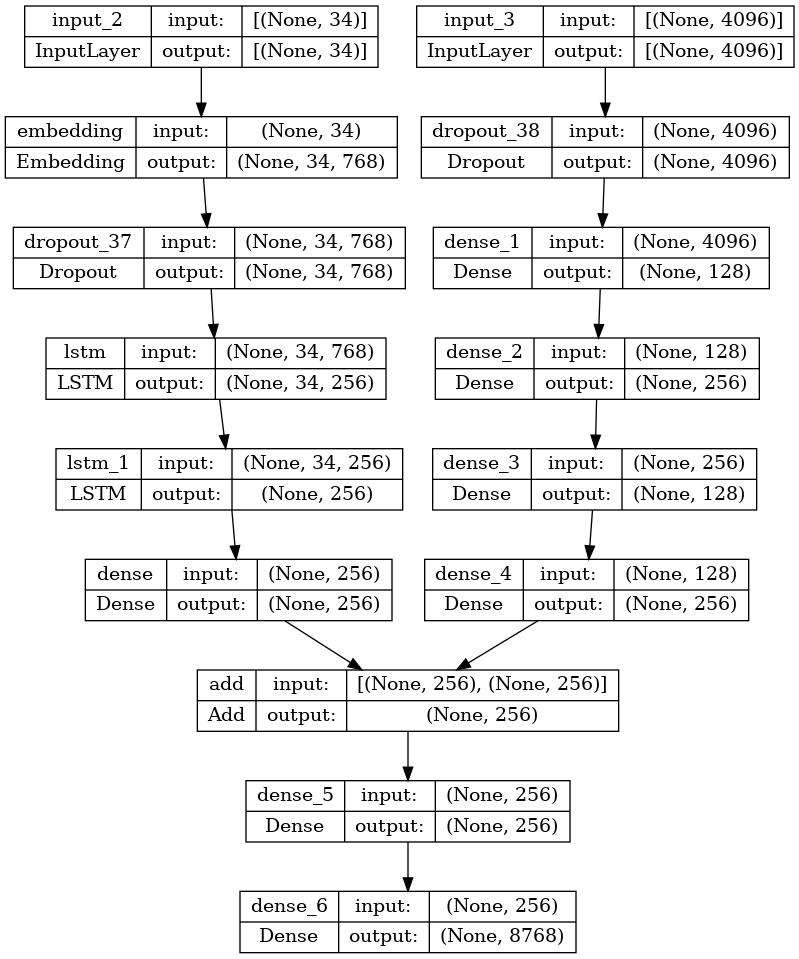

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

Vale ressaltar o uso de dropouts para evitar o overfit da rede e da loss "categorical_crossentropy"

# Criando gerador dos dados

Gerador de dados que prepara batches para o treinamento de um modelo de legendas de imagem.
Ele utiliza as características das imagens (vetor_imagens) e as legendas associadas (img_to_cap).
Para cada imagem e legenda:
- Divide as legendas em sequências de entrada (in_seq) e saídas esperadas (out_seq).
- Padroniza o tamanho das sequências e converte as saídas para one-hot encoding.
- Organiza os dados em batches do tamanho especificado (batch_size) e os retorna.
O gerador é usado em treinamento incremental com grandes volumes de dados.


In [25]:
print(len(vetor_imagens))
print(len(dict_img_to_captions))

8091
8091


In [26]:
print(max_length)
print(vocab_size)

34
8768


In [27]:
def data_generator(img_to_cap, vetor_imagens,batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for i in img_to_cap.keys():
            n += 1
            img = vetor_imagens[i][0]
            for cap in img_to_cap[i]:
                seq = tokenizer.texts_to_sequences([cap])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(img)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [28]:
#Testa o gerador de dados
gerador = data_generator(dict_img_to_captions, vetor_imagens, 32)
X, y = next(gerador)
print(X[0].shape)
print(X[1].shape)
print(y.shape)

(1746, 4096)
(1746, 34)
(1746, 8768)


# Treinamento do modelo

## Treino e teste split

In [29]:
import random

# Supondo que as chaves sejam as IDs das imagens
chaves_imagens = list(dict_img_to_captions.keys())

# Embaralha as chaves
#random.shuffle(chaves_imagens)

# Divide os dados em 80% treino e 20% teste
n_treino = int(len(chaves_imagens) * 0.9)
chaves_treino = chaves_imagens[:n_treino]
chaves_teste = chaves_imagens[n_treino:]

# Resultados
print(f"Treino: {len(chaves_treino)} imagens")
print(f"Teste: {len(chaves_teste)} imagens")


Treino: 7281 imagens
Teste: 810 imagens


In [31]:
train_dict_img_to_captions = {k: dict_img_to_captions[k] for k in chaves_treino}
test_dict_img_to_captions = {k: dict_img_to_captions[k] for k in chaves_teste}

## Treinamento 

In [232]:
epocas = 25
batche_size = 64
steps = len(train_dict_img_to_captions)//batche_size

generator = data_generator({k: dict_img_to_captions[k] for k in chaves_treino}, vetor_imagens, 64)
model.fit(generator, epochs=epocas, steps_per_epoch=steps, verbose=1)
# model.save(f'model/modelo_{epocas+75}.h5')

Epoch 1/25
113/113 [==============================] - 39s 283ms/step - loss: 5.6112
Epoch 2/25
113/113 [==============================] - 30s 263ms/step - loss: 4.4572
Epoch 3/25
113/113 [==============================] - 29s 256ms/step - loss: 3.9580
Epoch 4/25
113/113 [==============================] - 29s 259ms/step - loss: 3.6911
Epoch 5/25
113/113 [==============================] - 29s 260ms/step - loss: 3.5017
Epoch 6/25
113/113 [==============================] - 29s 255ms/step - loss: 3.3586
Epoch 7/25
113/113 [==============================] - 29s 255ms/step - loss: 3.2406
Epoch 8/25
113/113 [==============================] - 29s 253ms/step - loss: 3.1393
Epoch 9/25
113/113 [==============================] - 29s 253ms/step - loss: 3.0496
Epoch 10/25
113/113 [==============================] - 29s 255ms/step - loss: 2.9731
Epoch 11/25
113/113 [==============================] - 28s 252ms/step - loss: 2.9036
Epoch 12/25
113/113 [==============================] - 29s 256ms/step - lo

In [30]:
# model.save(f'model/modelo_bert.h5')
model.load_weights('model/modelo_bert.h5')

# Gerando legendas

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        # yhat = yhat.squeeze()
        # yhat = np.random.choice(len(yhat), p=yhat)
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

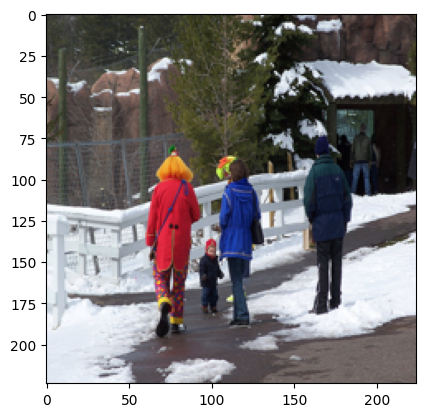

Caption: group of people are walking down the street lined on the side of the side of the side of the road
Real: toddler starting at clown walking down snowy sidewalk
Real: several people including child and clown are walking towards snowy sidewalk
Real: three adults and toddler stand on snowy path
Real: three adults and one child are walking along paved path that is snow covered
Real: two adults child and clown walking down sidewalk



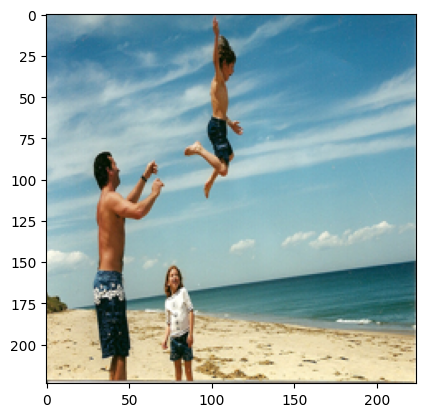

Caption: man in black and white shorts is running on the beach
Real: father with his two kids at the ocean with the young boy flying up in the air
Real: little boy jumps from his fathers arms on the beach
Real: man tosses boy into the air at the beach
Real: an adult man is throwing child into the air at beach while another child watches
Real: young boy is thrown by man as girl watches at the beach



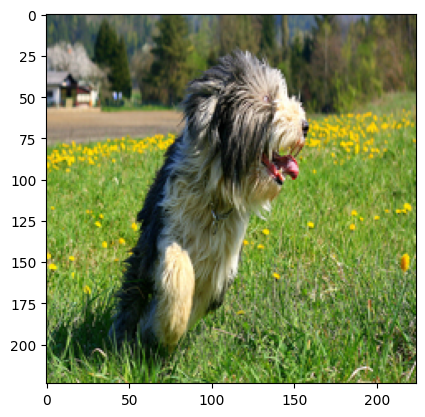

Caption: dog is jumping over hurdle
Real: big shaggy dog runs in field of dandylions
Real: dog running in field of daisies
Real: dog sitting in the grass with his tongue out
Real: long haired dog frolics in meadow of yellow flowers
Real: shaggy dog plays in field of grass and yellow flowers



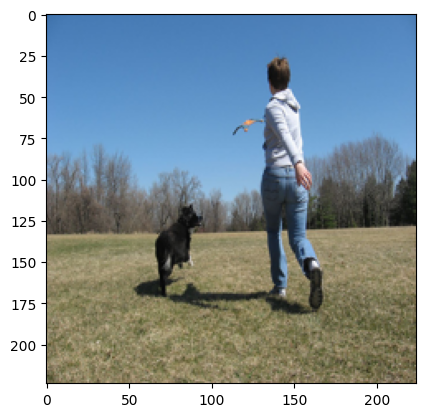

Caption: man in black coat is jumping up to throw ball
Real: black dog is in the grass with woman in jeans
Real: grey in grey sweashirt running alongside of small dog
Real: person playing with their black dog in the grass
Real: woman and dog are running in field
Real: woman flies kite in field while her dog watches



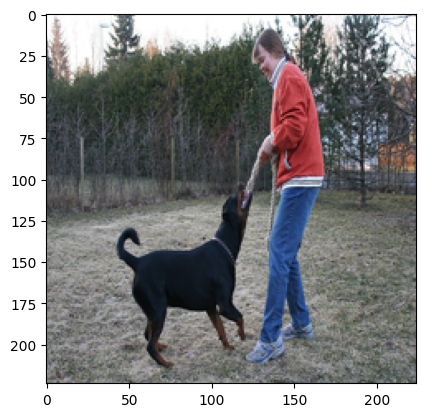

Caption: man in black jacket is walking through the grass with stick in his mouth
Real: black dog and woman in red shirt playing tug of war
Real: dog is pulling on one end of rope and girl is pulling on the other
Real: woman plays tugofwar with her black dog in brown landscape surrounded by trees
Real: woman plays with her rottweiler dog outside
Real: woman and dog playing outside



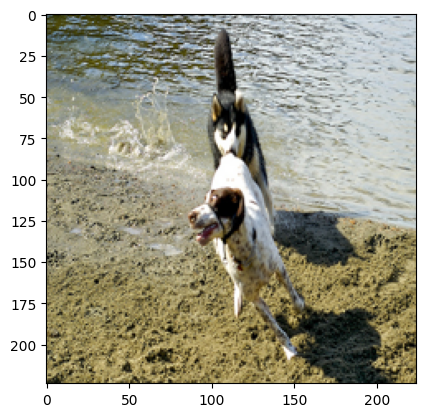

Caption: dog is shaking itself dry
Real: dog chasing another dog by lake
Real: husky chasing brown spoted dog at the shore
Real: two dogs spaniel and husky chase each other across the sand by body of water
Real: two dogs chase each other near the water
Real: two dogs playing by the shore



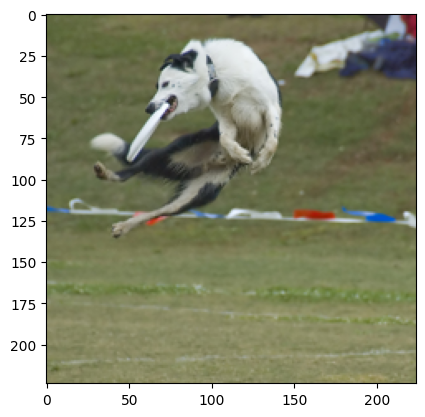

Caption: dog is chasing another dog in the grass
Real: black and white dog catches frisbee in midair
Real: black and white dog is midjump and has frisbee in his mouth
Real: black and white dog jumps up in the air to catch frisbee
Real: dog jumps in the air catching frisbee in its mouth
Real: white dog in jump holding plate in his mouth



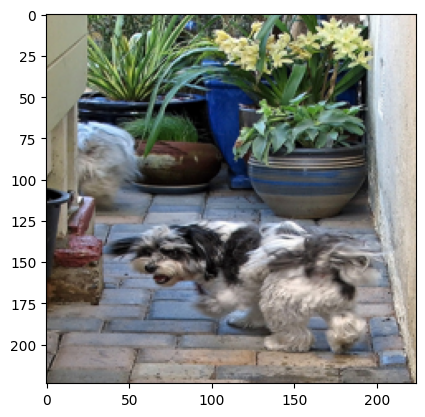

Caption: the black and white dog is standing on the steps in front of the building
Real: black and white dog is running up path towards some potted plants
Real: dog follows another dog around the corner but looks back
Real: dog is turns back toward the camera near some potted plants
Real: dog turning to look at the camera
Real: white and black dog in hallway filled with potted plants



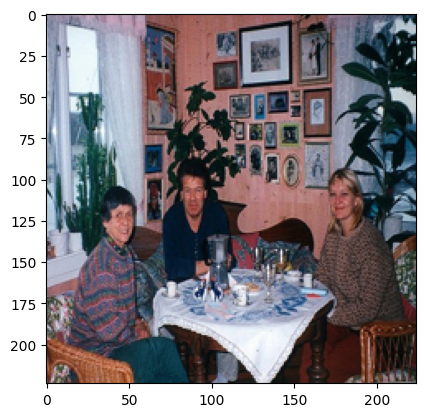

Caption: an old woman is sitting at table at table in front of restaurant
Real: group of people sitting around table drinking tea or coffee
Real: three individuals sit at table smiling
Real: three people gather around table for beverages
Real: three people gather around the table and have their picture taken
Real: two women and man sit at table having coffee in home



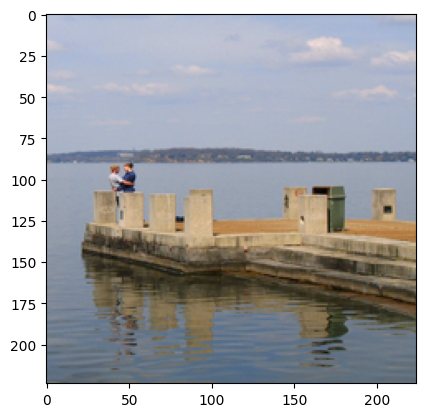

Caption: two people sit on dock near dock
Real: couple stands on dock by the water hugging
Real: stone dock and couple hugging at the end water behind
Real: two people are hugging at the end of stone jetty that looks out over the ocean
Real: two people embrace on the end of dock
Real: two people stand on the pier looking at the ocean and embrace



In [33]:
import matplotlib.pyplot as plt

for i in chaves_teste[76:86]:
    img = vetor_imagens[i]
    caption = predict_caption(model, img, tokenizer, max_length)
    img_path = os.path.join(IMAGES_PATH, i)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.show()
    print(f"Caption: {caption[9:-7]}")
    for cap in dict_img_to_captions[i]:
        print(f"Real: {cap[9:-7]}")
    print()

# Computando Bleu Score

In [174]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(candidate: str, references: list):
    """
    Calcula o BLEU score para uma frase candidata comparada a uma ou mais referências.

    Args:
        candidate (str): Texto gerado automaticamente.
        references (list): Lista de textos de referência.

    Returns:
        float: BLEU score.
    """
    # Suavização para lidar com n-gramas ausentes
    smoothing_function = SmoothingFunction().method1

    # Calcula o BLEU score
    bleu_score = sentence_bleu(references, candidate, smoothing_function=smoothing_function, weights=(1, 0, 0, 0))
    return bleu_score

In [175]:
scores = []
for i in tqdm(chaves_teste):
    img = vetor_imagens[i]
    caption = predict_caption(model, img, tokenizer, max_length)
    references = [cap for cap in dict_img_to_captions[i]]
    bleu = calculate_bleu(caption, references)
    scores.append(bleu)

print(f"BLEU médio: {np.mean(scores)}")

100%|██████████| 810/810 [10:35<00:00,  1.27it/s]

BLEU médio: 0.8909289758792662
